# Steps and comments

Import functions from modules. "tool" is just name for now, I haven't found a good name for it yet.

**[functions](https://github.com/dkbrz/GSoC_2018/blob/master/tool/functions.py) **

**[evaluation](https://github.com/dkbrz/GSoC_2018/blob/master/tool/evaluation.py) **

In [1]:
from tool.functions import *
from tool.evaluation import *

**Dependencies**

Dependencies are written in file with functions

In [ ]:
import logging, sys, os, requests, json, re
from collections import Counter 
from math import exp, log10
from itertools import islice
import networkx as nx
import xml.etree.ElementTree as ET
from github import Github           #Github library for downloading dictionaries
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import matplotlib.pyplot as plt     #some evaluation (optional)
from heapdict import heapdict
from tqdm import tqdm_notebook as tqdm   #progress bar (I use notebook function because I work only here)
import random
import numpy as np, scipy.stats as st

## Loading dictionaries

Function creates a folder "dictionaries" and loads all bilingual dictionaries from Apertium Github. For now I delete ces-ces, ita-ita, eus-eu_bis, hbs_HR-hbs_SR, zh_CN-zh_TW manually, because these languages have to be somehow distinguished from each other. EPO-BEL has wrong name (inside it is bel-epo) so this have to be manually changed.

**All dictionaries are on Github**

To load dictionaries, there has to be a file 'secure.json' containing:
```
{
  "USER": "<username>",
  "PASSWORD": "<password>"
}
```

In [2]:
%time download_all_bidixes()

2018-07-05 16:53:20,769 | INFO : Start
2018-07-05 17:00:39,382 | INFO : Finish
Wall time: 7min 20s


This one creates artificially created monolingual dictionaries that contain all bilingual etries for a particular language.

3 min

In [3]:
%time monodix()

2018-07-05 17:04:31,414 | INFO : started
2018-07-05 17:07:53,656 | INFO : finished
Wall time: 3min 22s


**There are some widgets below that can't be showed. It is just tqdm progress bar that is very useful. It will show up if you run the code.**

At this moment bilingual dictionary evaluation formula is:
    
$$ x = \frac 1{ log10( 10 + DictionaryLength )}$$

$$ Dictionary length = BothSides + 0.5 * LR + 0.5 * RL $$

So we don't go below zero as weight of the edge can't be negative

In [4]:
%time preprocessing()


Wall time: 1h 36min 36s


Now we have all we need: dictionaries and some statistical information.

## Working with language pair

Set languages that we want to work with (order like in bidix name)

In [2]:
lang1, lang2 = 'eng','spa'
n = 10

Create a file "language_list" that contains languages we can use in graph in descending order (from more useful to less useful). 

Wall time: 727 ms


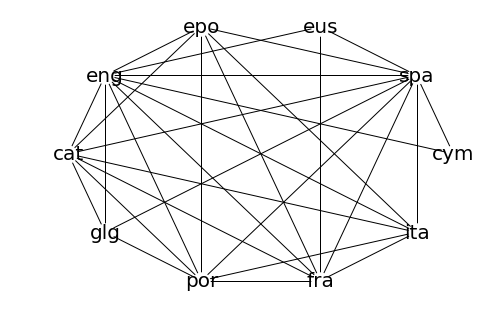

In [3]:
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

In [4]:
%time load_file(lang1, lang2, n=n)
%time change_encoding('{}-{}'.format(lang1,lang2))
%time G = built_from_file('{}-{}'.format(lang1,lang2))
%time l1, l2 = dictionaries(lang1, lang2)

Wall time: 1.19 s
Wall time: 705 ms
Wall time: 58.5 s
Wall time: 5.6 s


If we want to check manually, we can search by lemma.

- G: graph
- 'star' : lemma
- l1 : source language dictionary
- 'spa' : target language name
- 4 : cutoff - maximum path length (otherwise search is very slow, this parameter should be equal (or +1) to maximum path length between languages in our top-10 languages)
- 40 : number of closest candidates to evaluate
- n=5 : how many candidates to print

In [5]:
%time print_lemma_results(lemma_search (G, 'star', l1, 'spa', 4, 40), n = 5)

		 eng$star$[vblex]
spa$protagonizar$[vblex]	0.4821836326607207
spa$jugar$[vblex_vblex-vbact]	0.2840371146351084
spa$presentar$[vblex]	0.11074869476740849
spa$constar$[vblex]	0.09727280076923756
spa$tocar$[vblex]	0.0404276819945128

		 eng$star$[adj]
spa$estelar$[adj_adj-mf]	0.1268460281398451
spa$estupendo$[adj-GD_adj-GD-ND]	0.006737946999085467
spa$magnífico$[adj_adj-GD-ND_adj-GD]	0.006737946999085467

		 eng$star$[n_n-ND]
spa$estrella$[n-f_n_n-f-sg]	2.1957739681949104
spa$estelo$[n-m]	0.2712844579026809
spa$lucero$[n-m_n]	0.2712844579026809
spa$astro$[n_n-m]	0.19526883880421858
spa$estrella$[n-f-ND]	0.1470598691371015

Wall time: 297 ms


n_n-ND means that there are different tag combination for this word (n) and (n + ND) that are presumably the same (non contradictory)

Search is an optimized variant of NetworkX single_source_shortest_path_length. When we meet target language node, we stop so this saves some time. Furthermore, we take only n closest variant so this also saves a lot of time.

Formula in this example:

$$\sum_{i=1}^{number of simple paths} \exp^{-len(path_i)}$$

So we sum exponents with degree - length of simple path for all simple paths from source to target node. (And this for all n candidates). Then we sort them in descending order.

Search with larget cutoff takes a lot of time in so dense graph since we have to go furher and check all children in this subgraph

In [7]:
%time s = lemma_search (G, 'casa', l2, 'eng', 4, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 5, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 6, 40)

Wall time: 431 ms
Wall time: 2.43 s
Wall time: 15 s


## Evaluation

**How good is this instrument in translation prediction**

Loop does 1000 words (or less if dictionary is less than 1000) evaluation n_iter times to get more reliable result. It takes 1000 random words from first language that have only one translation and have at least one translation in some other language and tries to find a translation without this edge between these two nodes.

- 'eng', 'spa' : languages
- n : top-n languages to include in graph
- n: how many iterations we do
- cutoff : max length path

Numbers in parentheses - the boundaries of the confidence interval

In [8]:
%time loop('eng', 'spa', n=10, cutoff=4, n_iter=10)


[0.6457937388935454, 0.6220116850985273, 0.6432457880977809, 0.6277914370158566, 0.6293325382757077, 0.65022599342623, 0.6506713904691686, 0.6192727334924274, 0.6151071347414813, 0.6802412161679174]
(0.6242804553464764, 0.6524582757892522)
Wall time: 8min 27s


**How many entries we can add**

Addition says how many entries we can add. (portion of all bilingual entries). I don't know how many make sense, but this number shows how many have at least one candidate (with this cutoff) for translation in other language. 

- exist :  there is a translation in bilingual dictionary
- failed : we can't find any path to target language (at least with this cutoff, with longer paths translation can be worse)
- new : there is at least one candidate for being a translation for some word that has no translation in bilingual dictionary
- errors : word in not in a dictionary (comment below)

In [9]:
addition('eng', 'spa', n=10, cutoff=4)


Exist: 0.12210115829476491, failed: 0.07898593321797302, NEW: 0.062447735984964524, errors: 0.7364651725022976



Exist: 0.21854810247841025, failed: 0.4537990046024532, NEW: 0.1380087727511722, errors: 0.18964412016796434


English has 57 pairs so there could be a large variance in tags and entries. So this number can be explained.

# RUS-UKR

In [2]:
lang1, lang2 = 'rus','ukr'
n = 10
%time loop(lang1, lang2, n=n, cutoff=4, n_iter=10)


[0.17859814394197143, 0.17482400491599115, 0.16310644912255784, 0.16366513757263068, 0.1623904854951698, 0.15290086341049833, 0.15853305981143673, 0.17261634628244205, 0.16731034733854286, 0.17074997765056815]
(0.16084371055206204, 0.17209525255629976)
Wall time: 3min 13s


Wall time: 901 ms


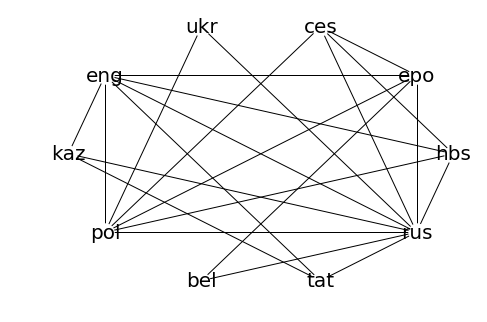

In [3]:
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

Bad results because only alternative (ukr-pol) is only 3k dictionary

# RUS-POL

Wall time: 999 ms


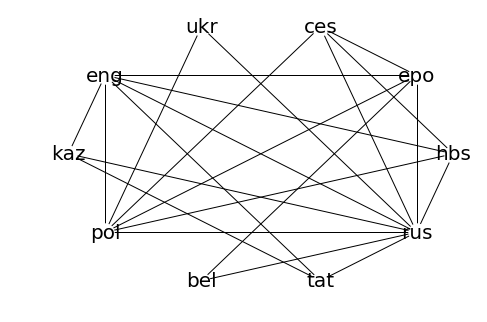

In [4]:
lang1, lang2 = 'pol','rus'
n = 10
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

In [5]:
%time loop(lang1, lang2, n=n, cutoff=4, n_iter=10)


[0.40149654103421506, 0.4303443813155992, 0.4204368117324654, 0.42854377071967126, 0.37078302114890915, 0.4101121126468221, 0.44792524019613533, 0.402557609627571, 0.47091625966625983, 0.47018092393207284]
(0.40276693100630084, 0.4478924033976434)
Wall time: 2min 20s


Rus-Pol is much better